Showing plots... (Check Figure 2 for the detailed LUT view)


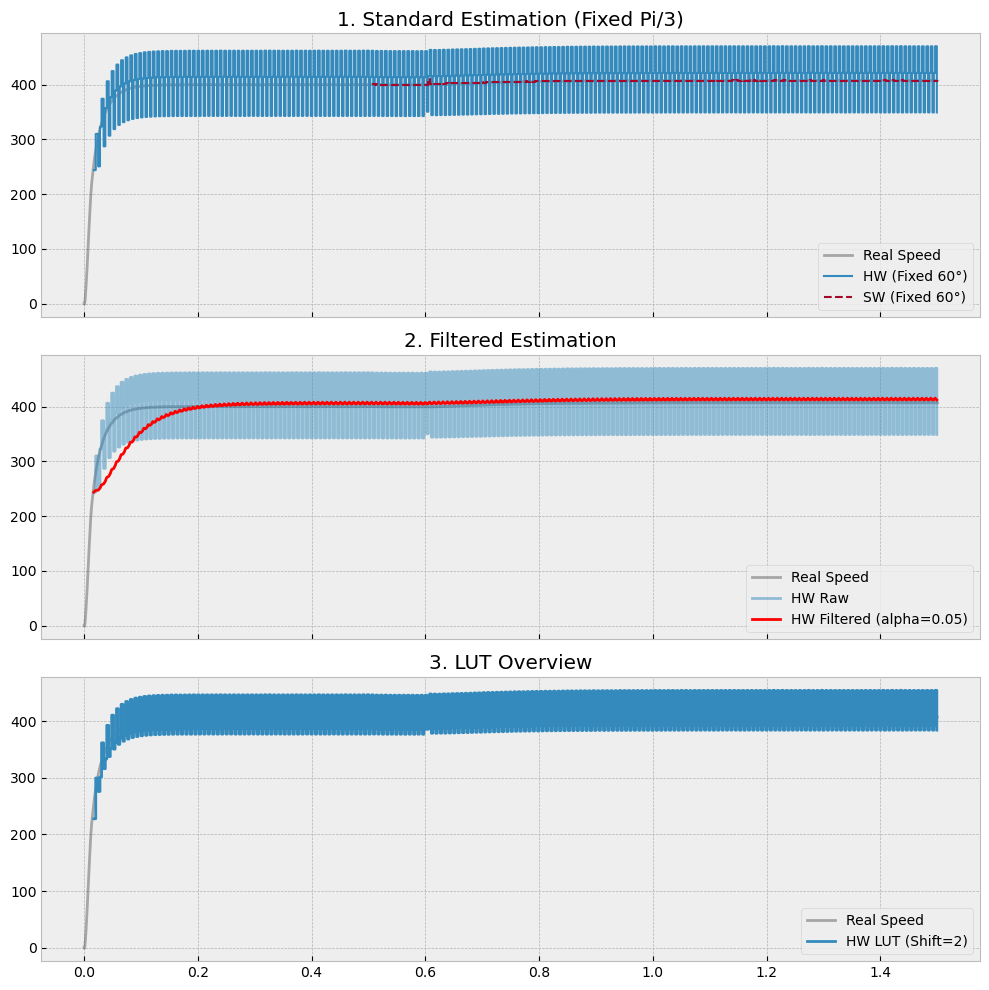

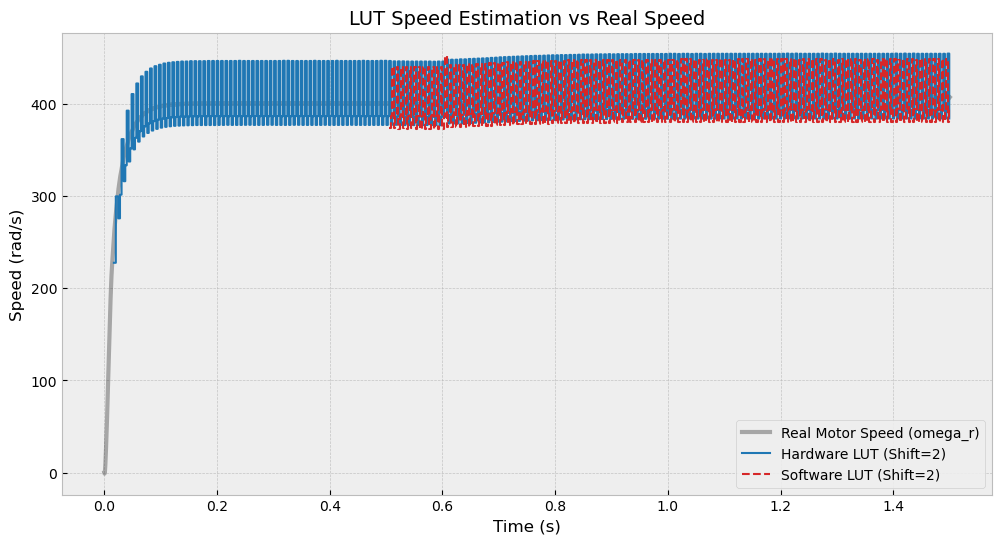

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from pathlib import Path

def load_mat_data(filepath):
    """Loads the .mat file using pathlib."""
    path_obj = Path(filepath)
    
    if not path_obj.exists():
        print(f"Error: File '{path_obj}' not found.")
        print(f"Absolute path checked: {path_obj.resolve()}")
        return None

    try:
        data = sio.loadmat(str(path_obj))
        # Flatten arrays to 1D
        struct = {
            'time': data['time'].flatten(),
            'omega_r': data['omega_r'].flatten(),
            'hardware_ISR': data['hardware_ISR'].flatten(),
            'software_ISR': data['software_ISR'].flatten()
        }
        return struct
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def find_rising_edges(signal):
    """
    Finds indices where signal transitions from low (<=0.5) to high (>0.5).
    """
    # signal[:-1] checks current state, signal[1:] checks next state
    rising_edges = (signal[:-1] <= 0.5) & (signal[1:] > 0.5)
    # Get indices (add 1 to get index of the 'high' value)
    return np.where(rising_edges)[0] + 1

def compute_speed(time, signal_name, signal, method='fixed', lut_angles_deg=None, lut_shift=0):
    """
    Calculates speed based on Rising Edge intervals (0 -> 1).
    """
    edge_indices = find_rising_edges(signal)
    
    if len(edge_indices) < 2:
        return np.array([]), np.array([])

    est_speed = []
    est_time = []
    
    for i in range(1, len(edge_indices)):
        idx_curr = edge_indices[i]
        idx_prev = edge_indices[i-1]
        
        dt = time[idx_curr] - time[idx_prev]
        
        if dt < 1e-6: continue

        if method == 'lut' and lut_angles_deg is not None:
            # Cycle through LUT based on edge count + shift
            lut_idx = (i + lut_shift) % len(lut_angles_deg)
            deg = lut_angles_deg[lut_idx]
            d_theta = np.deg2rad(deg)
        else:
            d_theta = np.pi / 3.0

        w = d_theta / dt
        est_speed.append(w)
        est_time.append(time[idx_curr])

    return np.array(est_time), np.array(est_speed)

def apply_low_pass(data, alpha=0.05):
    if len(data) == 0: return data
    filtered = np.zeros_like(data)
    filtered[0] = data[0]
    for i in range(1, len(data)):
        filtered[i] = (alpha * data[i]) + ((1 - alpha) * filtered[i-1])
    return filtered

def main():
    # ================= CONFIGURATION =================
    FILE_PATH = Path('mat_files') / 'speed_estimation_test.mat'
    
    # LUT Values (Degrees)
    LUT_ANGLES = np.array([55.998, 57.995, 65.991, 55.998, 57.994, 65.99])
    # LUT_ANGLES = np.array([57.981, 51.981, 69.978, 57.984, 51.983, 69.964])
    
    # Adjust these if the LUT estimation looks "jagged" or out of phase
    LUT_SHIFT_HW = 2  
    LUT_SHIFT_SW = 2

    ALPHA = 0.05
    # =================================================

    data = load_mat_data(FILE_PATH)
    if data is None: return

    # --- Calculations ---
    # 1. Standard
    t_hw, w_hw = compute_speed(data['time'], 'HW', data['hardware_ISR'], method='fixed')
    w_hw_filt = apply_low_pass(w_hw, alpha=ALPHA)
    t_sw, w_sw = compute_speed(data['time'], 'SW', data['software_ISR'], method='fixed')

    # 2. LUT
    t_lut_hw, w_lut_hw = compute_speed(data['time'], 'HW', data['hardware_ISR'], 
                                       method='lut', lut_angles_deg=LUT_ANGLES, lut_shift=LUT_SHIFT_HW)
    t_lut_sw, w_lut_sw = compute_speed(data['time'], 'SW', data['software_ISR'], 
                                       method='lut', lut_angles_deg=LUT_ANGLES, lut_shift=LUT_SHIFT_SW)

    # ================= FIGURE 1: OVERVIEW (Your original request) =================
    plt.style.use('bmh')
    fig1, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    fig1.canvas.manager.set_window_title('Overview: All Estimators')

    # Plot 1: Standard
    axes[0].plot(data['time'], data['omega_r'], 'k-', alpha=0.3, lw=2, label='Real Speed')
    axes[0].step(t_hw, w_hw, where='post', label='HW (Fixed 60°)', lw=1.5)
    axes[0].step(t_sw, w_sw, where='post', label='SW (Fixed 60°)', linestyle='--', lw=1.5)
    axes[0].set_title('1. Standard Estimation (Fixed Pi/3)')
    axes[0].legend(loc='lower right')

    # Plot 2: Filtered
    axes[1].plot(data['time'], data['omega_r'], 'k-', alpha=0.3, lw=2, label='Real Speed')
    axes[1].step(t_hw, w_hw, where='post', label='HW Raw', alpha=0.5)
    axes[1].plot(t_hw, w_hw_filt, 'r-', lw=2, label=f'HW Filtered (alpha={ALPHA})')
    axes[1].set_title('2. Filtered Estimation')
    axes[1].legend(loc='lower right')

    # Plot 3: LUT Small
    axes[2].plot(data['time'], data['omega_r'], 'k-', alpha=0.3, lw=2, label='Real Speed')
    axes[2].step(t_lut_hw, w_lut_hw, where='post', label=f'HW LUT (Shift={LUT_SHIFT_HW})')
    axes[2].set_title('3. LUT Overview')
    axes[2].legend(loc='lower right')
    
    plt.tight_layout()

    # ================= FIGURE 2: LUT FOCUSED (Detailed View) =================
    fig2, ax2 = plt.subplots(figsize=(12, 6))
    fig2.canvas.manager.set_window_title('Detailed View: LUT Estimation')

    # Real Speed (Thick, semi-transparent grey)
    ax2.plot(data['time'], data['omega_r'], color='black', alpha=0.3, linewidth=3, label='Real Motor Speed (omega_r)')

    # Hardware LUT (Solid Blue)
    ax2.step(t_lut_hw, w_lut_hw, where='post', color='#1f77b4', linewidth=1.5, 
             label=f'Hardware LUT (Shift={LUT_SHIFT_HW})')

    # Software LUT (Dashed Red - often overlaps HW, so using dashes helps visibility)
    ax2.step(t_lut_sw, w_lut_sw, where='post', color='#d62728', linestyle='--', linewidth=1.5, 
             label=f'Software LUT (Shift={LUT_SHIFT_SW})')

    ax2.set_title('LUT Speed Estimation vs Real Speed', fontsize=14)
    ax2.set_ylabel('Speed (rad/s)', fontsize=12)
    ax2.set_xlabel('Time (s)', fontsize=12)
    ax2.legend(loc='lower right', fontsize=10, frameon=True, fancybox=True, framealpha=0.9)
    ax2.grid(True, which='both', linestyle='--', alpha=0.7)

    print("Showing plots... (Check Figure 2 for the detailed LUT view)")
    plt.show()

if __name__ == "__main__":
    main()


--- Hardware ISR Ground Truth Statistics ---
Sector   | Mean (deg)   | Std Dev    | Count 
---------------------------------------------
0        | 65.981       | 0.048      | 96    
1        | 48.487       | 0.036      | 95    
2        | 65.484       | 0.046      | 95    
3        | 65.983       | 0.042      | 95    
4        | 48.488       | 0.033      | 95    
5        | 65.476       | 0.108      | 95    
---------------------------------------------
Total Sum: 359.900 degrees (Should be close to 360)

>>> Copy this array for your Python/MATLAB scripts: <<<
LUT_ANGLES = np.array([65.981, 48.487, 65.484, 65.983, 48.488, 65.476])


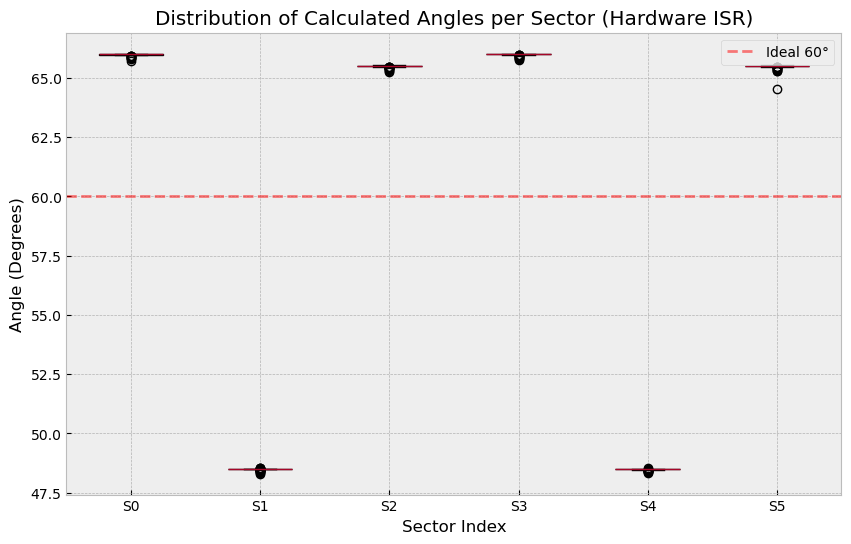

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from pathlib import Path
import pandas as pd

def load_mat_data(filepath):
    path_obj = Path(filepath)
    if not path_obj.exists():
        print(f"Error: File '{path_obj}' not found.")
        return None
    try:
        data = sio.loadmat(str(path_obj))
        struct = {
            'time': data['time'].flatten(),
            'omega_r': data['omega_r'].flatten(),
            'hardware_ISR': data['hardware_ISR'].flatten(),
            'software_ISR': data['software_ISR'].flatten()
        }
        return struct
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def find_rising_edges(signal):
    # Finds indices where signal transitions 0 -> 1
    return np.where((signal[:-1] <= 0.5) & (signal[1:] > 0.5))[0] + 1

def calculate_angles_per_sector(data, signal_name, signal, shift=0):
    edge_indices = find_rising_edges(signal)
    
    if len(edge_indices) < 2:
        print(f"Not enough edges for {signal_name}")
        return {}

    # Store angles for each sector (0 to 5)
    sector_angles = {i: [] for i in range(6)}
    
    # Iterate through intervals
    for i in range(1, len(edge_indices)):
        idx_curr = edge_indices[i]
        idx_prev = edge_indices[i-1]
        
        # 1. Get Time Delta
        t_start = data['time'][idx_prev]
        t_end = data['time'][idx_curr]
        dt = t_end - t_start
        
        if dt < 1e-6: continue

        # 2. Get Average Real Speed during this interval
        # We slice the omega_r array corresponding to this time window
        w_slice = data['omega_r'][idx_prev:idx_curr]
        
        if len(w_slice) == 0: continue
            
        w_avg = np.mean(w_slice)
        
        # 3. Calculate Angle: Theta = w * t
        d_theta_rad = w_avg * dt
        d_theta_deg = np.rad2deg(d_theta_rad)
        
        # Filter out obvious startup noise (e.g., if angle is tiny or massive)
        if d_theta_deg < 10 or d_theta_deg > 100:
            continue

        # 4. Assign to Sector (Cycle 0-5)
        # We assume the first interval (i=1) corresponds to sector (0 + shift)
        sector_idx = (i - 1 + shift) % 6
        sector_angles[sector_idx].append(d_theta_deg)

    return sector_angles

def print_stats(sector_angles, label):
    print(f"\n--- {label} Statistics ---")
    print(f"{'Sector':<8} | {'Mean (deg)':<12} | {'Std Dev':<10} | {'Count':<6}")
    print("-" * 45)
    
    means = []
    
    for i in range(6):
        vals = sector_angles[i]
        if len(vals) > 0:
            mu = np.mean(vals)
            sigma = np.std(vals)
            count = len(vals)
            means.append(mu)
            print(f"{i:<8} | {mu:<12.3f} | {sigma:<10.3f} | {count:<6}")
        else:
            means.append(0)
            print(f"{i:<8} | {'N/A':<12} | {'N/A':<10} | 0")
            
    print("-" * 45)
    print(f"Total Sum: {sum(means):.3f} degrees (Should be close to 360)")
    return np.array(means)

# ================= MAIN EXECUTION =================
FILE_PATH = Path('mat_files') / 'speed_estimation_test.mat'
data = load_mat_data(FILE_PATH)

if data is not None:
    # Adjust shift if your Sector 0 is actually Sector 1, etc.
    SHIFT = 0 
    
    # 1. Calculate
    hw_angles = calculate_angles_per_sector(data, "Hardware", data['hardware_ISR'], shift=SHIFT)
    
    # 2. Print Report
    hw_means = print_stats(hw_angles, "Hardware ISR Ground Truth")
    
    # 3. Generate Copy-Paste Array
    print("\n>>> Copy this array for your Python/MATLAB scripts: <<<")
    print("LUT_ANGLES = np.array([", end="")
    print(", ".join([f"{x:.3f}" for x in hw_means]), end="])\n")

    # 4. Boxplot to visualize consistency
    plt.figure(figsize=(10, 6))
    plt.style.use('bmh')
    
    # Prepare data for boxplot
    plot_data = [hw_angles[i] for i in range(6)]
    
    plt.boxplot(plot_data, labels=[f"S{i}" for i in range(6)], patch_artist=True)
    plt.title('Distribution of Calculated Angles per Sector (Hardware ISR)')
    plt.ylabel('Angle (Degrees)')
    plt.xlabel('Sector Index')
    plt.axhline(60, color='r', linestyle='--', alpha=0.5, label='Ideal 60°')
    plt.legend()
    plt.show()


--- Hardware ISR (Physical) Statistics ---
Sector   | Mean (deg)   | Std Dev    | Count 
---------------------------------------------
0        | 57.981       | 0.056      | 95    
1        | 51.981       | 0.047      | 95    
2        | 69.978       | 0.061      | 95    
3        | 57.984       | 0.049      | 95    
4        | 51.983       | 0.043      | 95    
5        | 69.964       | 0.168      | 95    
---------------------------------------------
Total Sum: 359.870 deg

--- Software ISR (Observed) Statistics ---
Sector   | Mean (deg)   | Std Dev    | Count 
---------------------------------------------
0        | 59.979       | 0.057      | 65    
1        | 59.980       | 0.046      | 65    
2        | 59.937       | 0.204      | 64    
3        | 59.974       | 0.069      | 64    
4        | 59.976       | 0.048      | 64    
5        | 59.961       | 0.076      | 64    
---------------------------------------------
Total Sum: 359.807 deg


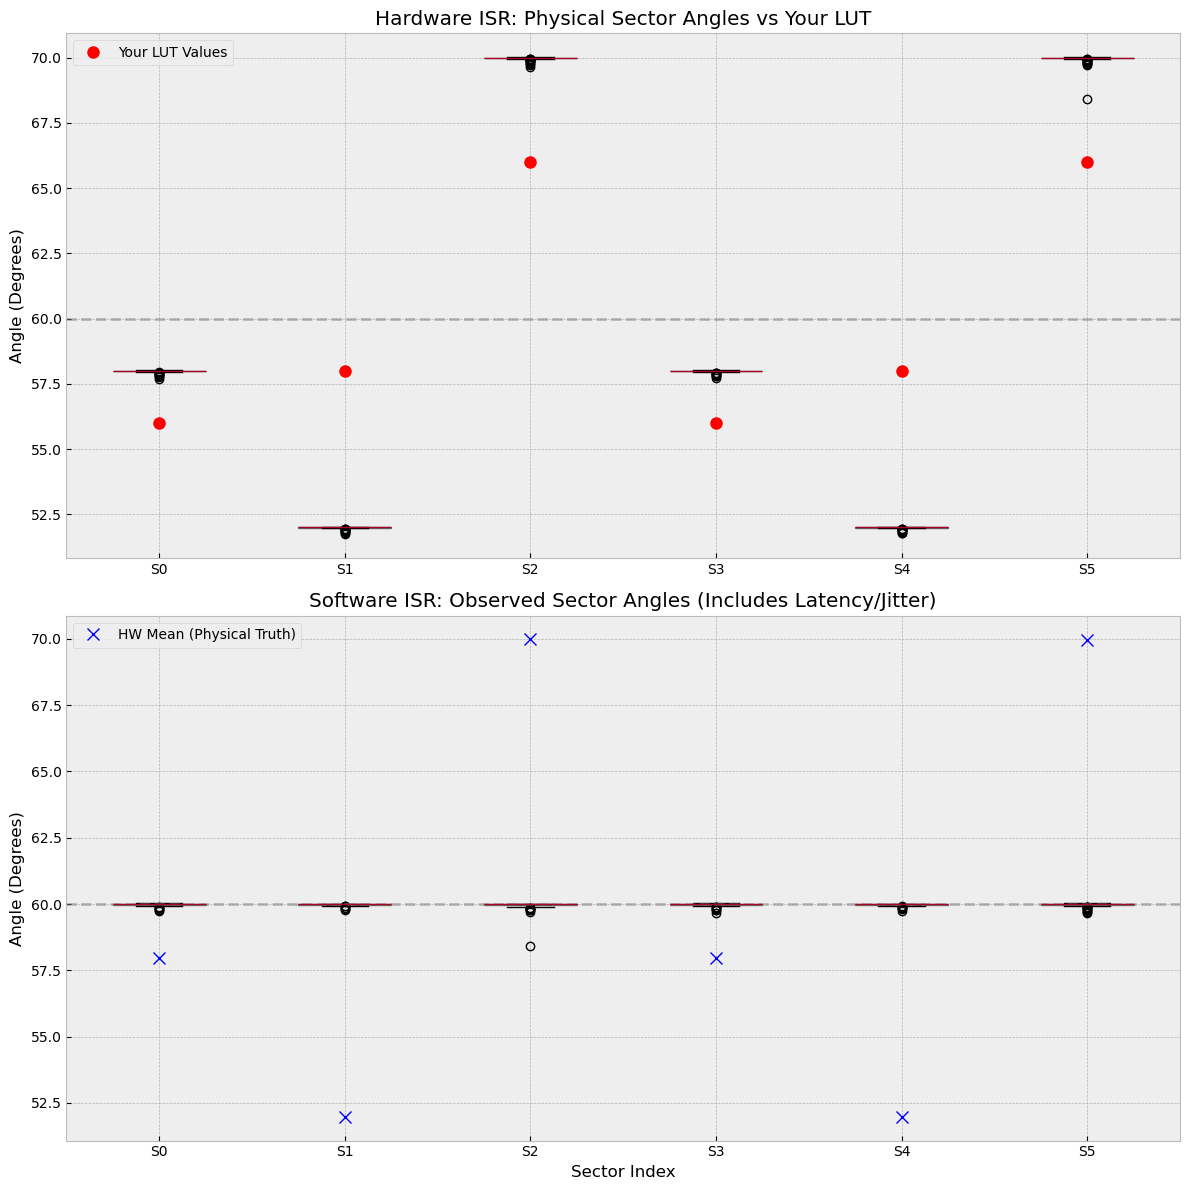

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from pathlib import Path

def load_mat_data(filepath):
    path_obj = Path(filepath)
    if not path_obj.exists():
        print(f"Error: File '{path_obj}' not found.")
        return None
    try:
        data = sio.loadmat(str(path_obj))
        return {
            'time': data['time'].flatten(),
            'omega_r': data['omega_r'].flatten(),
            'hardware_ISR': data['hardware_ISR'].flatten(),
            'software_ISR': data['software_ISR'].flatten()
        }
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def find_rising_edges(signal):
    return np.where((signal[:-1] <= 0.5) & (signal[1:] > 0.5))[0] + 1

def calculate_angles_per_sector(data, signal_name, signal, shift=0):
    edge_indices = find_rising_edges(signal)
    
    if len(edge_indices) < 2:
        return {}

    sector_angles = {i: [] for i in range(6)}
    
    for i in range(1, len(edge_indices)):
        idx_curr = edge_indices[i]
        idx_prev = edge_indices[i-1]
        
        t_start = data['time'][idx_prev]
        t_end = data['time'][idx_curr]
        dt = t_end - t_start
        
        if dt < 1e-6: continue

        # Get real speed average over this interval
        w_slice = data['omega_r'][idx_prev:idx_curr]
        if len(w_slice) == 0: continue
            
        w_avg = np.mean(w_slice)
        
        # Calculate Angle: Theta = w * t
        d_theta_deg = np.rad2deg(w_avg * dt)
        
        if 10 < d_theta_deg < 100:
            sector_idx = (i - 1 + shift) % 6
            sector_angles[sector_idx].append(d_theta_deg)

    return sector_angles

def print_stats(sector_angles, label):
    print(f"\n--- {label} Statistics ---")
    print(f"{'Sector':<8} | {'Mean (deg)':<12} | {'Std Dev':<10} | {'Count':<6}")
    print("-" * 45)
    
    means = []
    for i in range(6):
        vals = sector_angles[i]
        if len(vals) > 0:
            mu = np.mean(vals)
            sigma = np.std(vals)
            means.append(mu)
            print(f"{i:<8} | {mu:<12.3f} | {sigma:<10.3f} | {len(vals):<6}")
        else:
            means.append(0)
            print(f"{i:<8} | {'N/A':<12} | {'N/A':<10} | 0")
    
    total = sum(means)
    print("-" * 45)
    print(f"Total Sum: {total:.3f} deg")
    return np.array(means)

def main():
    # ================= CONFIGURATION =================
    FILE_PATH = Path('mat_files') / 'speed_estimation_test.mat'
    
    # YOUR TARGET LUT VALUES (to overlay)
    USER_LUT = np.array([55.998, 57.995, 65.991, 55.998, 57.994, 65.99])

    # SHIFT (Adjust if needed to align Sector 0)
    SHIFT = 0 
    # =================================================

    data = load_mat_data(FILE_PATH)
    if data is None: return

    # 1. Calculate Hardware ISR Angles (Ground Truth)
    hw_angles = calculate_angles_per_sector(data, "Hardware", data['hardware_ISR'], shift=SHIFT)
    hw_means = print_stats(hw_angles, "Hardware ISR (Physical)")

    # 2. Calculate Software ISR Angles (Software "View")
    sw_angles = calculate_angles_per_sector(data, "Software", data['software_ISR'], shift=SHIFT)
    sw_means = print_stats(sw_angles, "Software ISR (Observed)")

    # ================= PLOTTING =================
    plt.style.use('bmh')
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    
    # --- Plot 1: Hardware ISR (Ground Truth) ---
    ax = axes[0]
    plot_data_hw = [hw_angles[i] for i in range(6)]
    ax.boxplot(plot_data_hw, labels=[f"S{i}" for i in range(6)], patch_artist=True, 
               boxprops=dict(facecolor='#1f77b4', alpha=0.5))
    
    # Overlay User LUT
    ax.plot(range(1, 7), USER_LUT, 'ro', markersize=8, label='Your LUT Values', zorder=10)
    
    ax.set_title('Hardware ISR: Physical Sector Angles vs Your LUT')
    ax.set_ylabel('Angle (Degrees)')
    ax.axhline(60, color='gray', linestyle='--', alpha=0.5)
    ax.legend()
    ax.grid(True)

    # --- Plot 2: Software ISR (What the code sees) ---
    ax = axes[1]
    plot_data_sw = [sw_angles[i] for i in range(6)]
    ax.boxplot(plot_data_sw, labels=[f"S{i}" for i in range(6)], patch_artist=True,
               boxprops=dict(facecolor='#2ca02c', alpha=0.5))
    
    # Overlay Hardware Means for Comparison
    ax.plot(range(1, 7), hw_means, 'bx', markersize=8, label='HW Mean (Physical Truth)', zorder=10)
    
    ax.set_title('Software ISR: Observed Sector Angles (Includes Latency/Jitter)')
    ax.set_ylabel('Angle (Degrees)')
    ax.set_xlabel('Sector Index')
    ax.axhline(60, color='gray', linestyle='--', alpha=0.5)
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

Testing all 6 shifts...
Done. Look for the flat line!


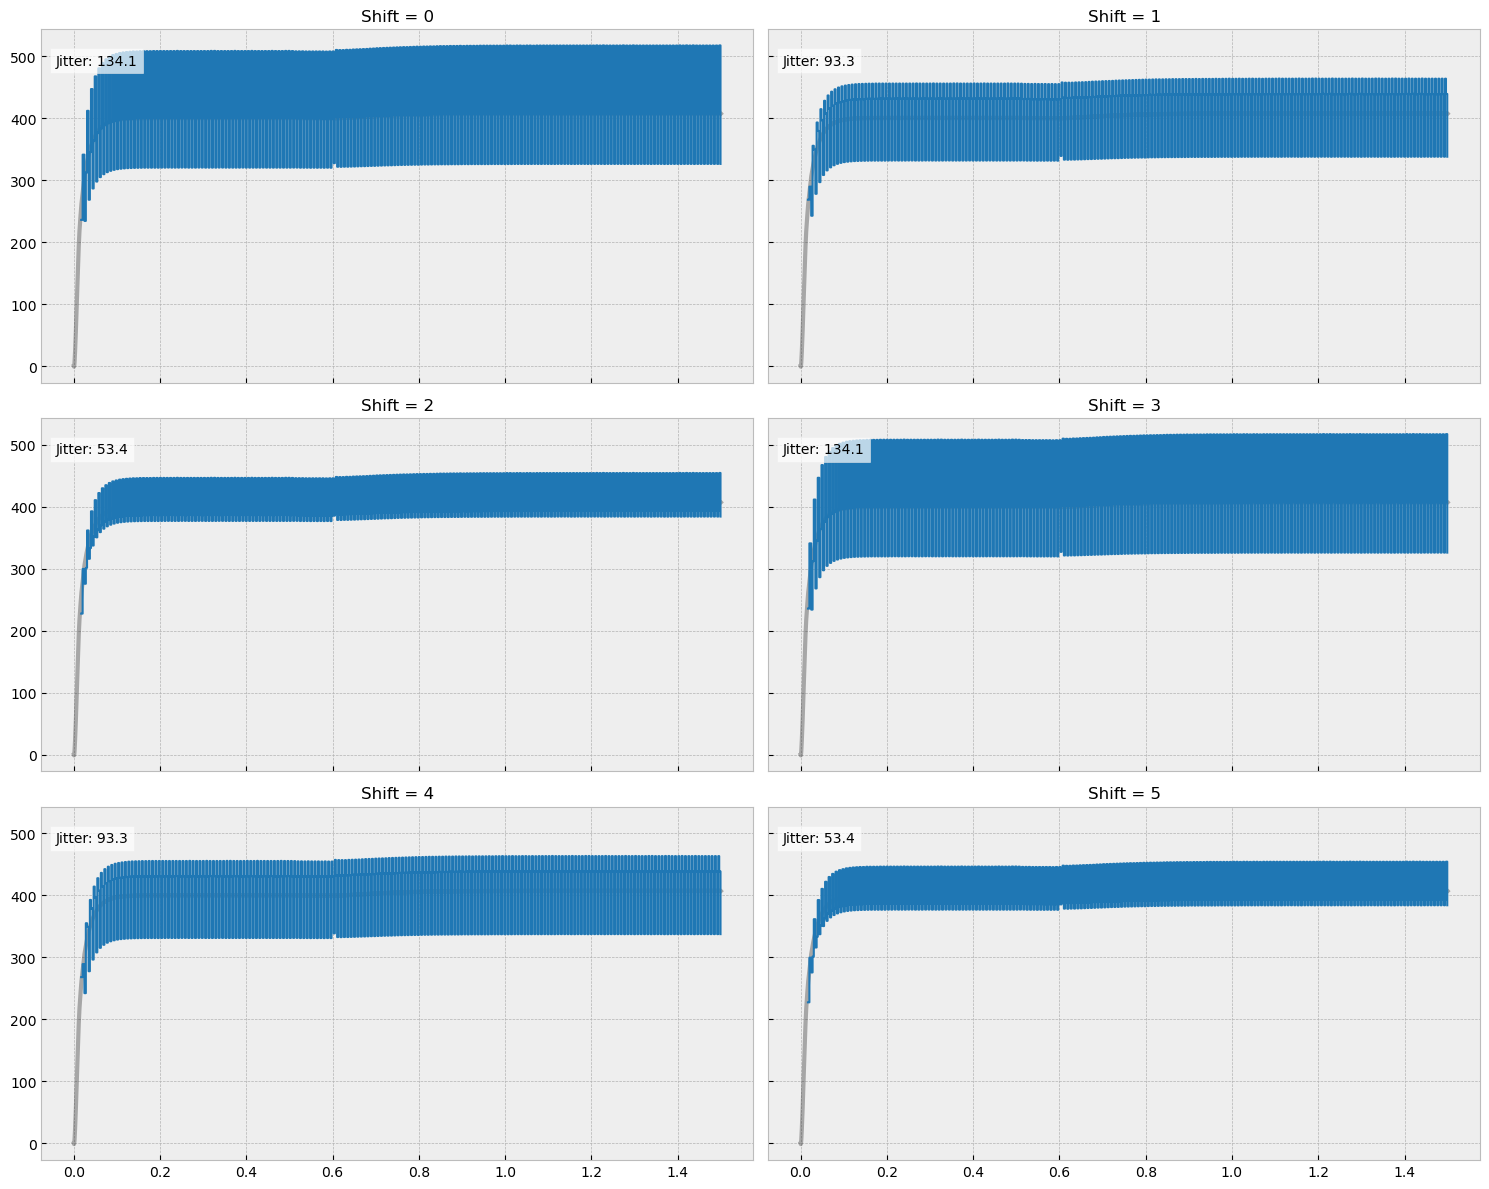

In [40]:
def main():
    # ================= CONFIGURATION =================
    FILE_PATH = Path('mat_files') / 'speed_estimation_test.mat'
    
    # Your calculated angles
    # LUT_ANGLES = np.array([57.981, 51.981, 69.978, 57.984, 51.983, 69.964])
    LUT_ANGLES = np.array([55.998, 57.995, 65.991, 55.998, 57.994, 65.99])
    
    # =================================================

    data = load_mat_data(FILE_PATH)
    if data is None: return

    # Create a 3x2 grid of plots to test all 6 shifts
    plt.style.use('bmh')
    fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True, sharey=True)
    fig.canvas.manager.set_window_title('LUT Shift Finder')
    axes = axes.flatten()

    print("Testing all 6 shifts...")

    for shift in range(6):
        # Compute speed with this specific shift
        t_lut, w_lut = compute_speed(data['time'], 'HW', data['hardware_ISR'], 
                                     method='lut', lut_angles_deg=LUT_ANGLES, lut_shift=shift)
        
        ax = axes[shift]
        # Plot Real Speed
        ax.plot(data['time'], data['omega_r'], 'k-', alpha=0.3, lw=3, label='Real')
        # Plot Estimated Speed
        ax.step(t_lut, w_lut, where='post', color='#1f77b4', lw=1.5, label='Estimate')
        
        ax.set_title(f'Shift = {shift}', fontsize=12)
        ax.grid(True)
        
        # Calculate Variance (Lower is better)
        # We assume the "best" one is the one that fluctuates least relative to the mean
        if len(w_lut) > 10:
             # simple metric: standard deviation of the difference between adjacent points
             smoothness = np.std(np.diff(w_lut))
             ax.text(0.02, 0.9, f'Jitter: {smoothness:.1f}', transform=ax.transAxes, 
                     bbox=dict(facecolor='white', alpha=0.7))

    plt.tight_layout()
    print("Done. Look for the flat line!")
    plt.show()

if __name__ == "__main__":
    main()